# Task 2. Search by Country and Institute

In this part we evaluate the contribution of Countries and institutes in this field of research.

Differently from Task 1, we count the occurences through the `dask.dataframe` framework, after selecting the appropriate fields through a bag.

## Imports

In [3]:
#Dask
from dask.distributed import Client, SSHCluster, wait
import dask.bag as db
import dask.dataframe as dd

#Other
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re
import pandas as pd
import geonamescache as gps
import time
import funky as f
import logging
logging.getLogger("distributed").setLevel(logging.WARNING)

## Cluster / Client setup

In [ ]:
cluster = SSHCluster(['localhost', 'localhost', '10.67.22.125', '10.67.22.104', '10.67.22.89'],
                     connect_options={'known_hosts': None},
                     scheduler_options={"port": 8786, "dashboard_address": ":8797", },
                     worker_options={'nthreads':1, 'n_workers':4})
client = Client("localhost:8786")

## Import data and Preprocessing

We implement a few mapping functions in order to retrieve the data from the `metadata` dictionaries, and deal with spurious fields. There are similar versions of the functions as they are used to test the `persist()` functionality.

For this part of the project we consider only the `pdf_json` directory since all the files in the `pmc_json` directory host empty `affiliation` fields.

In [6]:
meta_block = os.path.getsize('/mnt/data/20/metadata.csv') // 32  
meta = dd.read_csv('/mnt/data/20/metadata.csv', blocksize=meta_block, dtype='string')
print(meta.npartitions)

common_path = '/mnt/data/20/'
pdj = meta['pdf_json_files']

pdf = (common_path + pdj[pdj.notnull()]).replace(r"\;.+", "", regex=True)
paths = pdf.compute().to_list()

# Bag creation
bag = db.from_sequence(paths, npartitions=64).map(lambda path: json.load(open(path))) 

32


In [7]:
# init. variables
countries = set([i.lower() for i in gps.GeonamesCache().get_countries_by_names().keys()]) - {'democratic republic of the congo', 'united arab emirates'} | {'brasil', 'congo', 'arab', 'usa', 'uk'}
regex = "|".join(re.escape(p) for p in countries)
print(regex)

# Filtering functions
def country_substitute(record):
    if record == 'brasil': return 'brazil'
    if record == 'usa': return 'united states'
    if record == 'uk': return 'united kingdom'
    return record

## For version 1
def get_country(record):
    authors=record['authors']
    if not authors: return None
    affiliation= [aut['affiliation'] for aut in authors if aut['affiliation']]
    if not affiliation: return None
    location=[aff['location'] for aff in affiliation if aff['location']]
    if not location: return None
    countries=[]
    for loc in location:
        try:
            if loc['country']: countries.append(re.findall(regex, loc['country'].lower()))
        except: pass
    return countries if countries else None

def get_inst(record): 
    authors=record['authors']
    if not authors: return None
    affiliation= [aut['affiliation'] for aut in authors if aut['affiliation']]
    if not affiliation: return None
    institution=[aff['institution'].lower().strip() for aff in affiliation if aff['institution'].lower().strip()]
    return institution if institution else None

## For version 2
def bag_pers(record): 
    authors=record['authors']
    if not authors: return None
    affiliation = [aut['affiliation'] for aut in authors if aut['affiliation']]
    return affiliation if affiliation else None

def get_country_pers(affiliation): 
    location=[aff['location'] for aff in affiliation if aff['location']]
    if not location: return None
    countries=[]
    for loc in location:
        try:
            if loc['country']: countries.append(re.findall(regex, loc['country'].lower()))
        except: pass
    return countries if countries else None

def get_inst_pers(affiliation):
    institution=[aff['institution'].lower() for aff in affiliation]
    return institution if institution else None



french\ polynesia|saudi\ arabia|venezuela|pitcairn|mongolia|india|tanzania|south\ sudan|new\ zealand|azerbaijan|sint\ maarten|bahamas|dominica|sri\ lanka|svalbard\ and\ jan\ mayen|turkmenistan|cook\ islands|guernsey|guam|iraq|libya|marshall\ islands|romania|colombia|ecuador|malta|sweden|zambia|american\ samoa|senegal|vanuatu|croatia|angola|faroe\ islands|taiwan|botswana|kiribati|palau|antigua\ and\ barbuda|indonesia|bermuda|fiji|curacao|south\ africa|heard\ island\ and\ mcdonald\ islands|lesotho|dominican\ republic|malawi|mozambique|nauru|gibraltar|sierra\ leone|czechia|uruguay|falkland\ islands|egypt|el\ salvador|andorra|haiti|timor\ leste|slovenia|serbia\ and\ montenegro|australia|cocos\ islands|saint\ pierre\ and\ miquelon|tuvalu|guinea\-bissau|united\ kingdom|togo|slovakia|turkey|saint\ helena|south\ korea|japan|french\ southern\ territories|christmas\ island|uk|paraguay|united\ states|latvia|france|niger|maldives|puerto\ rico|mayotte|lithuania|nepal|eritrea|benin|china|suriname|br

## Word search

We perform the task by filtering out the missing data, flattening the result, and then converting it into a Dask `DataFrame` and applying to it the `value_counts()` function.

We try two different approaches. 
- The first is the direct computation of both queries. 
- The second is an alternative version that implements the `persist()` function. Since the first part of the computation is the same for both tasks, we keep it separate and store it in advance as the object `data1`. We then use `data1` to complete the computation, finishing the mapping functions and the count for each field.

### Version 1: direct computation

In [9]:
data_country_1 = bag.pluck('metadata').map(get_country).filter(bool).flatten().flatten().map(country_substitute)\
    .to_dataframe(meta=pd.DataFrame(columns=['Country'],dtype='string'))['Country'].value_counts(sort=True).compute()

data_institute_1 = bag.pluck('metadata').map(get_inst).filter(bool).flatten()\
    .to_dataframe(meta=pd.DataFrame(columns=['Institution'], dtype='string'))['Institution'].value_counts(sort=True).compute()

### Version 2: using `persist`

In [ ]:
data1 = bag.pluck('metadata').map(bag_pers).filter(bool).persist()

data_country_2=data1.map(get_country_pers).filter(bool).flatten().flatten().map(country_substitute)\
    .to_dataframe(meta=pd.DataFrame(columns=['Country'],dtype='string'))['Country'].value_counts(sort=True).compute()

data_institute_2=data1.map(get_inst_pers).filter(bool).flatten()\
    .to_dataframe(meta=pd.DataFrame(columns=['Institution'],dtype='string'))['Institution'].value_counts(sort=True).compute()

### Results

Barplots of the most and least active Countries and institutes.

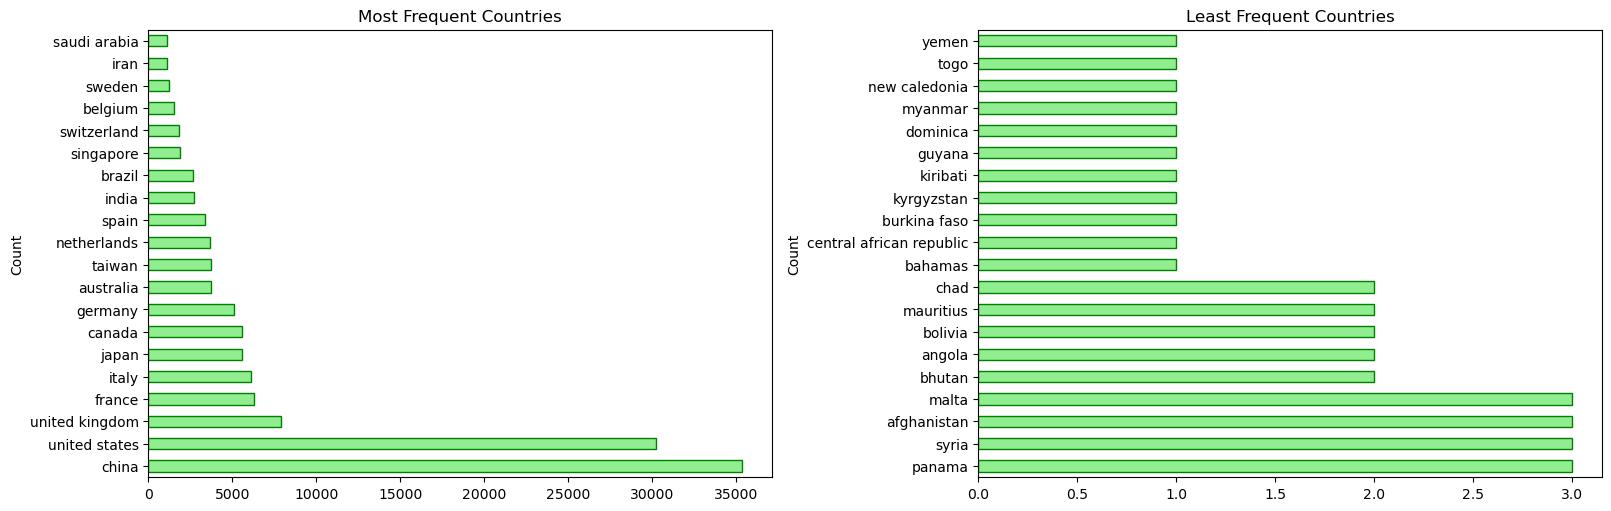

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 5), layout="constrained")

data_country_1.head(20).plot(kind='barh', xlabel="", ylabel="Count", legend=False, color='lightgreen', edgecolor='green', ax=ax[0], title='Most Frequent Countries')
data_country_1.tail(20).plot(kind='barh', xlabel="", ylabel="Count", legend=False, color='lightgreen', edgecolor='green', ax=ax[1], title='Least Frequent Countries')
plt.show()

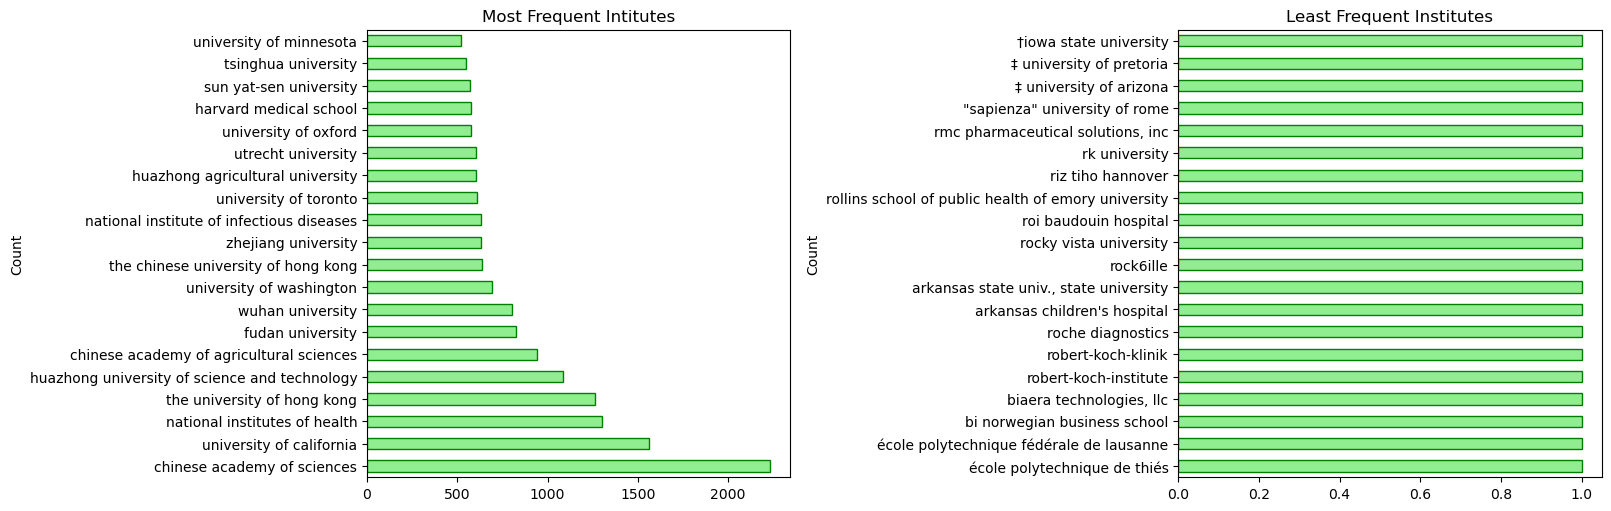

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 5), layout="constrained")

data_institute_1.head(20).plot(kind='barh', xlabel="", ylabel="Count", legend=False, color='lightgreen', edgecolor='green', ax=ax[0], title='Most Frequent Intitutes')
data_institute_1.tail(20).plot(kind='barh', xlabel="", ylabel="Count", legend=False, color='lightgreen', edgecolor='green', ax=ax[1], title='Least Frequent Institutes')
plt.show()

## Benchmarking

The workflow consisted in executing the following cells (one for each version) with different configurations of the cluster and the bag, i.e. modifying the parameters `n_workers`, `n_threads`, and `n_partitions` in the Bag. We timed each execution three times and stored in a csv file the result in seconds for each computation.

In [ ]:
## Version 1
# Modify the cells below to try different configurations.
n_workers=[1,2]
n_threads=[1,2]
mult_partitions=[1,3,6,10,100]

# Benchmarking cycle
for j in range(len(mult_partitions)):
    for i in range(len(n_threads)):

        n_partitions = 4 * n_workers[i] * n_threads[i] * mult_partitions[j]
        string_country = str(n_workers[i])+','+str(n_threads[i])+','+str(n_partitions)
        string_institute = str(n_workers[i])+','+str(n_threads[i])+','+str(n_partitions)
        
        for k in range(3):

            # Restart cluster with new parameters
            print('Restarting cluster ...')            
            cluster = SSHCluster(['localhost', 'localhost', '10.67.22.125', '10.67.22.104', '10.67.22.89'],
                            connect_options={'known_hosts': None},
                            scheduler_options={"port": 8786, "dashboard_address": ":8797"},
                            worker_options={'nthreads':n_threads[i], 'n_workers':n_workers[i]})
            client=Client(cluster)
            
            # Timing operation. The code is the same as above
            print('Starting run ',j+1,'-',i+1,'-',k+1)
            data1 = db.from_sequence(paths, npartitions=(n_partitions-1)).map(lambda path: json.load(open(path))).pluck('metadata')

            # Country
            start = time.time()
            data_country_1 = data1.map(get_country).filter(bool).flatten().flatten().map(country_substitute).to_dataframe(meta=pd.DataFrame(columns=['Country'],dtype='string'))['Country'].value_counts(sort=True).compute()
            end = time.time()
            string_country += ',' + str(np.round(end-start,2))
            del data_country_1

            # Institute
            start = time.time()
            data_institute_1 = data1.map(get_inst).filter(bool).flatten().to_dataframe(meta=pd.DataFrame(columns=['Institution'], dtype='string'))['Institution'].value_counts(sort=True).compute()
            end = time.time()
            string_institute += ',' + str(np.round(end-start,2))

            client.shutdown()

        # Write into file    
        with open("bm_2_compute_country_1.csv", "a") as fin: fin.write(string_country + '\n')
        with open("bm_2_compute_institute_1.csv", "a") as fin: fin.write(string_institute + '\n')
        
        print('End of runs',j+1,'-',i+1)
        
print('End of all runs!')

In [ ]:
## Version 2
# Modify the cells below to try different configurations.
n_workers=[1,2]
n_threads=[1,2]
mult_partitions=[1,3,6,10,100]

# Benchmarking cycle
for j in range(len(mult_partitions)):
    for i in range(len(n_threads)):

        n_partitions = 4 * n_workers[i] * n_threads[i] * mult_partitions[j]
        string_data1 = str(n_workers[i])+','+str(n_threads[i])+','+str(n_partitions)
        string_country = str(n_workers[i])+','+str(n_threads[i])+','+str(n_partitions)
        string_institute = str(n_workers[i])+','+str(n_threads[i])+','+str(n_partitions)
        
        for k in range(3):

            # Restart cluster with new parameters
            print('Restarting cluster ...')
            cluster = SSHCluster(['localhost', 'localhost', '10.67.22.125', '10.67.22.104', '10.67.22.89'],
                            connect_options={'known_hosts': None},
                            scheduler_options={"port": 8786, "dashboard_address": ":8797"},
                            worker_options={'nthreads':n_threads[i], 'n_workers':n_workers[i]})
            client=Client(cluster)
            
            # Timing operation
            print('Starting run ',j+1,'-',i+1,'-',k+1)
            
            # Persist operation
            start = time.time()            
            data1 = db.from_sequence(paths, npartitions=(n_partitions-1)).map(lambda path: json.load(open(path))).pluck('metadata').map(bag_pers).filter(bool).persist()   
            wait(data1)
            end = time.time()
            string_data1 += ',' + str(np.round(end-start,2))

            # Country
            start = time.time()
            data_country_2=data1.map(get_country_pers).filter(bool).flatten().flatten().map(country_substitute).to_dataframe(meta=pd.DataFrame(columns=['Country'],dtype='string'))['Country'].value_counts(sort=True).compute()
            end = time.time()
            string_country += ',' + str(np.round(end-start,2))
            del data_country_2

            # Institute
            start = time.time()
            data_institute_2 = data1.map(get_inst_pers).filter(bool).flatten().to_dataframe(meta=pd.DataFrame(columns=['Institution'],dtype='string'))['Institution'].value_counts(sort=True).compute()
            end = time.time()
            string_institute += ',' + str(np.round(end-start,2))

            client.shutdown()
        
        # Write into file
        with open("bm_2_persist_bag_1.csv", "a") as fin: fin.write(string_data1 + '\n')
        with open("bm_2_persist_country_1.csv", "a") as fin: fin.write(string_country + '\n')
        with open("bm_2_persist_institute_1.csv", "a") as fin: fin.write(string_institute + '\n')
        
        print('End of runs',j+1,'-',i+1)
        
print('End of all runs!')

## Benchmarking results

We show below the most relevant results of our benchmarking process.

In the first set of plots, we plot the average execution times of the first version of the computation (first and second row) as well as the times of the `persist()` operation applied to the bag in the second version of the computation (third row).

In each Axes are compared, given a total number of threads, the performances of different cluster configurations (`n_workers`, `n_threads`) varying the number of partitions (`n_partitions`). 

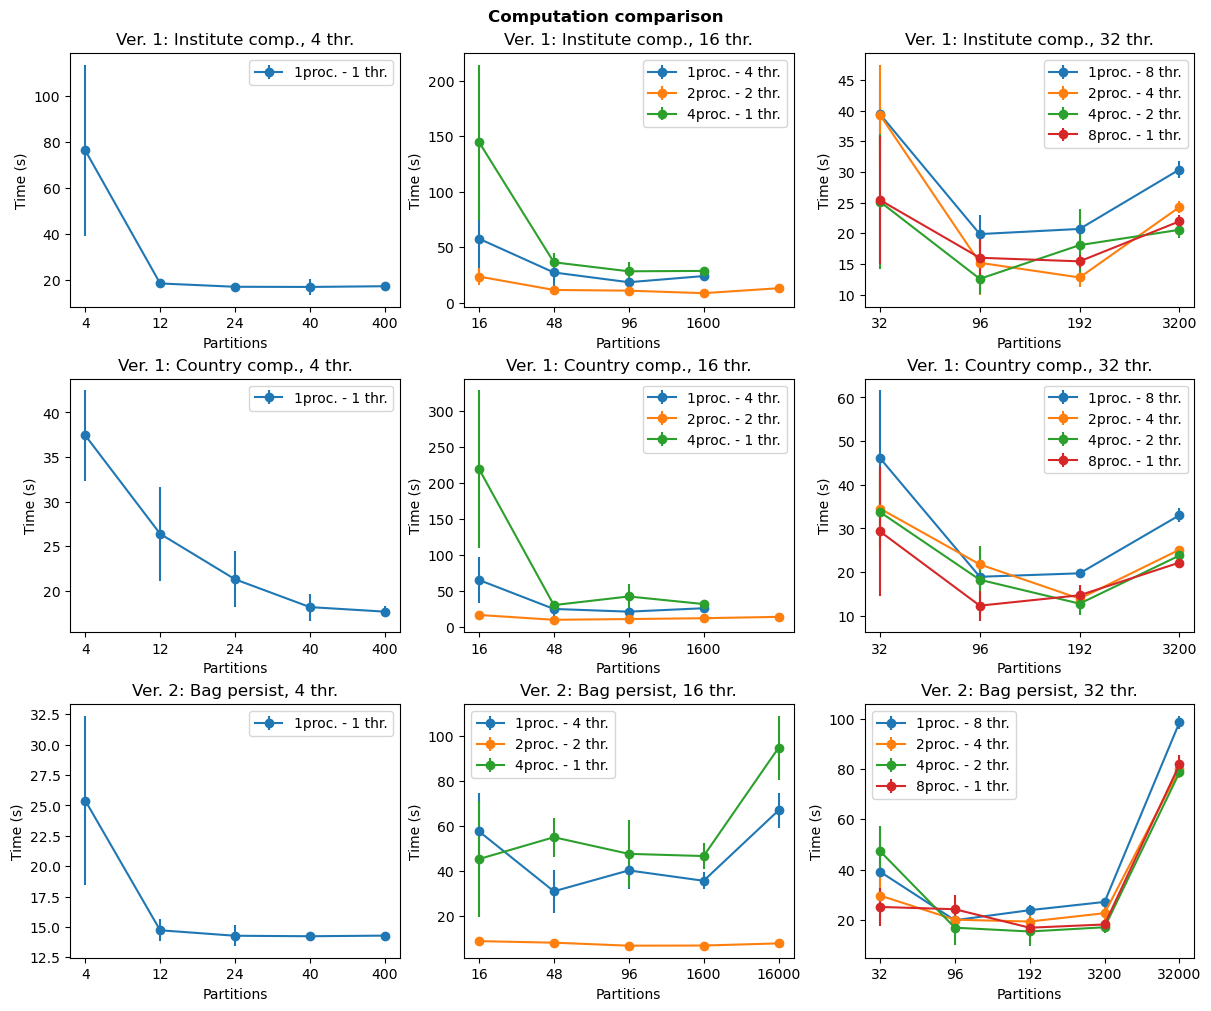

In [35]:
fig,ax=plt.subplots(3,3,figsize=(12,10),layout='constrained')
fig.suptitle('Computation comparison', weight="bold")
threads=[ 4,16, 32]

for i in range(3):
    f.plot_performances(f'bm/bm_2_compute_institute{threads[i]}.csv',0,i,ax, title='Ver. 1: Institute comp.')
    f.plot_performances(f'bm/bm_2_compute_country{threads[i]}.csv',1,i,ax, title='Ver. 1: Country comp.')
    f.plot_performances(f'bm/bm_2_persist_bag{threads[i]}.csv',2,i,ax, title='Ver. 2: Bag persist')

Given the plot above, we can affirm that the three rows behave very similarly, and in particular, the operation `persist()` applied to the bag shows similar performances to the other two with respect to the specific cluster configurations (e.g., 2 proc - 2thr is the fastest configuration). 

We can then, for each total thread number (4,16,32), choose a configuration and compare its computation times for the first version (without persist) and the second version (with persist).

We plot below the total execution times of the first version (country and institute search without persisting) along with the total execution times of the second task (persist of the bag, followed by country and institute count).

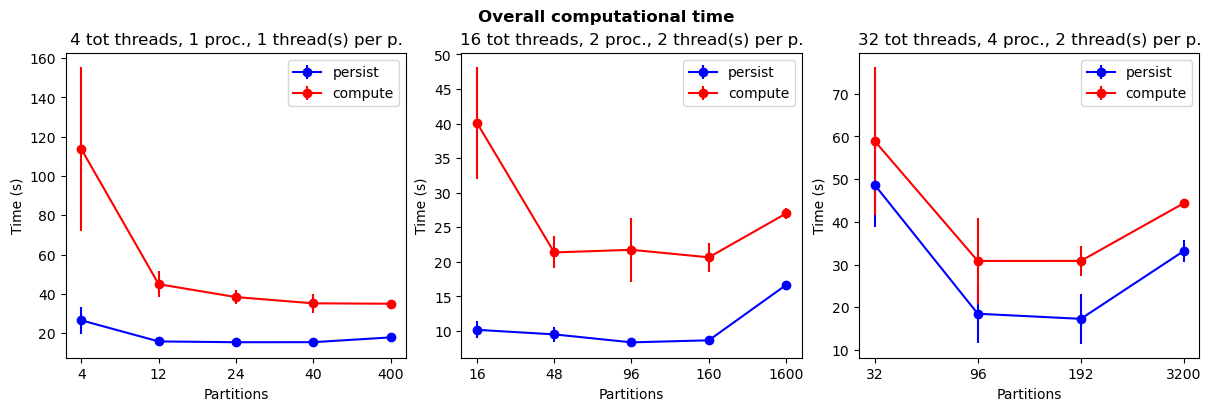

In [36]:
fig,ax=plt.subplots(1,3,figsize=(12,4),layout='constrained')
fig.suptitle('Overall computational time', weight="bold")
threads=[4,16,32]
workers=[1,2,4]
for i in range(3):
    df1=pd.read_csv(f'bm/bm_2_persist_bag{threads[i]}.csv')
    df2=pd.read_csv(f'bm/bm_2_persist_country{threads[i]}.csv')
    df3=pd.read_csv(f'bm/bm_2_persist_institute{threads[i]}.csv')
    df1=df1[df1['n_partitions']<=15000]
    df2=df2[df2['n_partitions']<=15000]
    df3=df3[df3['n_partitions']<=15000]
    
    df1['time1']=df1['time1']+df2['time1']+df3['time1']
    df1['time2']=df1['time2']+df2['time2']+df3['time2']
    df1['time3']=df1['time3']+df2['time3']+df3['time3']

    df2=pd.read_csv(f'bm/bm_2_compute_country{threads[i]}.csv')
    df3=pd.read_csv(f'bm/bm_2_compute_institute{threads[i]}.csv')

    df2['time1']=df2['time1']+df3['time1']
    df2['time2']=df2['time2']+df3['time2']
    df2['time3']=df2['time3']+df3['time3']

    df1=df1[df1['n_workers']==workers[i]]
    df2=df2[df2['n_workers']==workers[i]]

    df1['mean']=(df1['time1']+df1['time2']+df1['time3'])/3
    df2['mean']=(df2['time1']+df2['time2']+df2['time3'])/3
    df1['std']=np.round(np.std([df1['time1'],df1['time2'],df1['time3']],axis=0),2)
    df2['std']=np.round(np.std([df2['time1'],df2['time2'],df2['time3']],axis=0),2)
        
    ax[i].errorbar(x=range(len(df1['n_partitions'])),y=df1['mean'],yerr=df1['std'],label=f'persist',fmt='o-',c='b')
    ax[i].errorbar(x=range(len(df2['n_partitions'])),y=df2['mean'],yerr=df2['std'],label=f'compute',fmt='o-',c='r')
    thr=int(threads[i]/4 /workers[i])
    ax[i].set_title(f'{threads[i]} tot threads, {workers[i]} proc., {thr} thread(s) per p.')
    ax[i].set_xlabel('Partitions')
    ax[i].set_ylabel('Time (s)')
    ax[i].set_xticks(range(len(df1['n_partitions'])))
    ax[i].set_xticklabels(np.array(df1['n_partitions'],dtype=int))
    ax[i].legend()
      

From the graph above, it is clear that persisting the first common part of the computation is useful since the total times are always better than computing separately the two tasks.

In [37]:
client.shutdown()